
# Diabetes Prediction Analysis
**Author:** Sajjad Ali Shah  
**LinkedIn:** [Sajjad Ali Shah](https://www.linkedin.com/in/sajjad-ali-shah47/)  
**Dataset:** [Diabetes Dataset](https://www.kaggle.com/datasets/johndasilva/diabetes)  

This notebook performs a comprehensive analysis for diabetes prediction, including data exploration, feature engineering, visualizations, and machine learning model evaluation.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import pickle
warnings.filterwarnings('ignore')

# Set modern seaborn theme
sns.set_theme(style='whitegrid', palette='husl')

In [33]:
# CELL 6: CODE
# Define dataset path
dataset_path = './dataset/diabetes.csv'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f'Dataset not found at {dataset_path}. Please ensure the file exists.')

In [34]:
df = pd.read_csv(dataset_path)

print('Dataset Shape:', df.shape)
print('\nDataset Info:')
print(df.info())
print('\nMissing Values:')
print(df.isnull().sum())
print('\nDuplicate Rows:', df.duplicated().sum())

Dataset Shape: (2000, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB
None

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                      

In [35]:
# Check for zero values in columns where they don't make sense
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print('\nZero Values Check:')
for col in zero_cols:
    print(f'{col}: {(df[col] == 0).sum()} zero values')

df.head()


Zero Values Check:
Glucose: 13 zero values
BloodPressure: 90 zero values
SkinThickness: 573 zero values
Insulin: 956 zero values
BMI: 28 zero values


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [36]:
# CELL 9: CODE
df = df.copy()

# Handle zero values
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    df[col] = df[col].replace(0, df[col].median())

# Create categorical features
df['BMI_Category'] = pd.cut(df['BMI'], 
                          bins=[0, 18.5, 25, 30, 100], 
                          labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

df['Glucose_Level'] = pd.cut(df['Glucose'],
                            bins=[0, 99, 125, 200],
                            labels=['Normal', 'Prediabetes', 'Diabetes'])

df['Age_Group'] = pd.cut(df['Age'],
                        bins=[0, 30, 45, 60, 100],
                        labels=['Young', 'Middle', 'Senior', 'Elderly'])

# Log transform skewed features
df['Insulin_Log'] = np.log1p(df['Insulin'])
df['DPF_Log'] = np.log1p(df['DiabetesPedigreeFunction'])

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Glucose_Level,Age_Group,Insulin_Log,DPF_Log
0,2,138,62,35,40,33.6,0.127,47,1,Obese,Diabetes,Senior,3.713572,0.119559
1,0,84,82,31,125,38.2,0.233,23,0,Obese,Normal,Young,4.836282,0.209450
2,0,145,72,23,40,44.2,0.630,31,1,Obese,Diabetes,Middle,3.713572,0.488580
3,0,135,68,42,250,42.3,0.365,24,1,Obese,Diabetes,Young,5.525453,0.311154
4,1,139,62,41,480,40.7,0.536,21,0,Obese,Diabetes,Young,6.175867,0.429182


In [37]:
# CELL 12: CODE
# Create directory for plots
os.makedirs('plots', exist_ok=True)


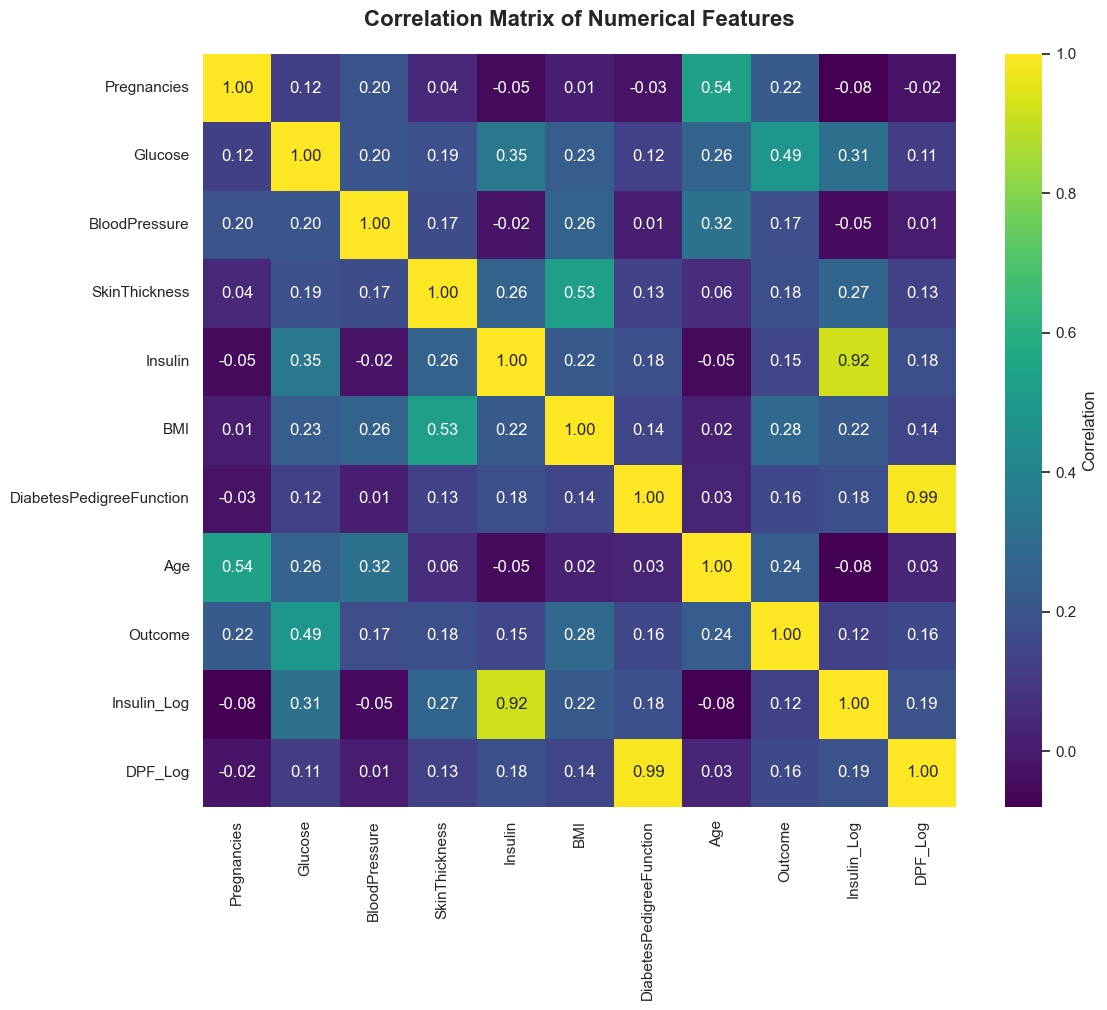

In [38]:
# 1. Correlation Heatmap
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f', square=True, 
            annot_kws={'size': 12}, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Numerical Features', pad=20, fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('plots/correlation_matrix.png', dpi=300)
plt.show()
plt.close()

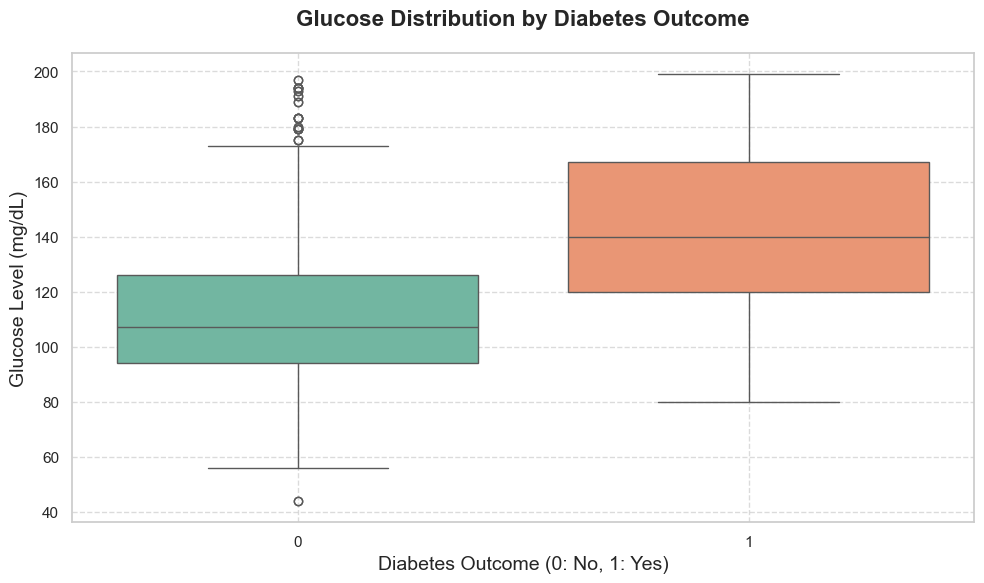

In [39]:
# 2. Glucose Distribution by Outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='Outcome', y='Glucose', data=df, palette='Set2')
plt.title('Glucose Distribution by Diabetes Outcome', pad=20, fontsize=16, weight='bold')
plt.xlabel('Diabetes Outcome (0: No, 1: Yes)', fontsize=14)
plt.ylabel('Glucose Level (mg/dL)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/glucose_distribution.png', dpi=300)
plt.show()
plt.close()

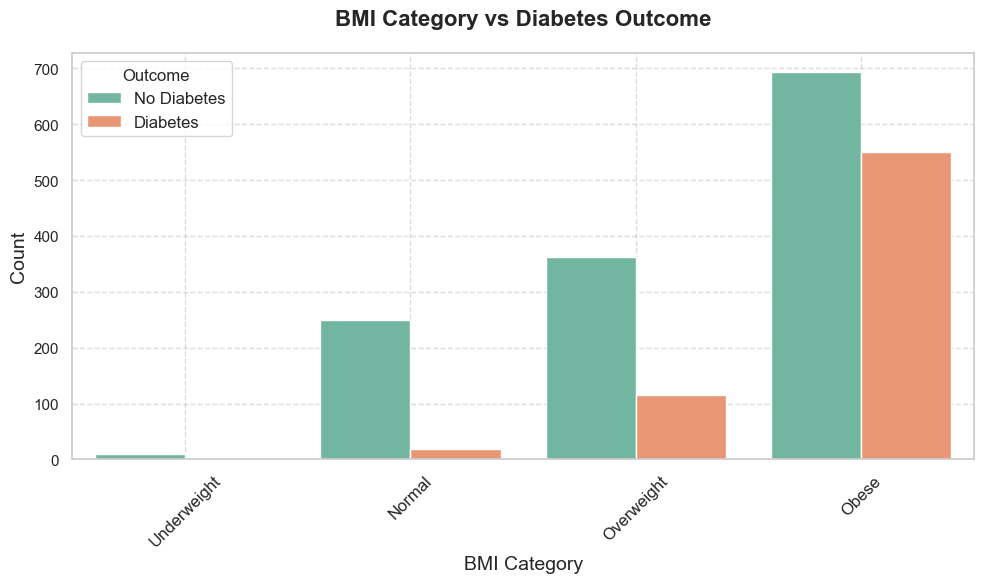

In [40]:
# 3. BMI Category Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='BMI_Category', hue='Outcome', data=df, palette='Set2')
plt.title('BMI Category vs Diabetes Outcome', pad=20, fontsize=16, weight='bold')
plt.xlabel('BMI Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Outcome', labels=['No Diabetes', 'Diabetes'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('plots/bmi_category_distribution.png', dpi=300)
plt.show()
# plt.close()

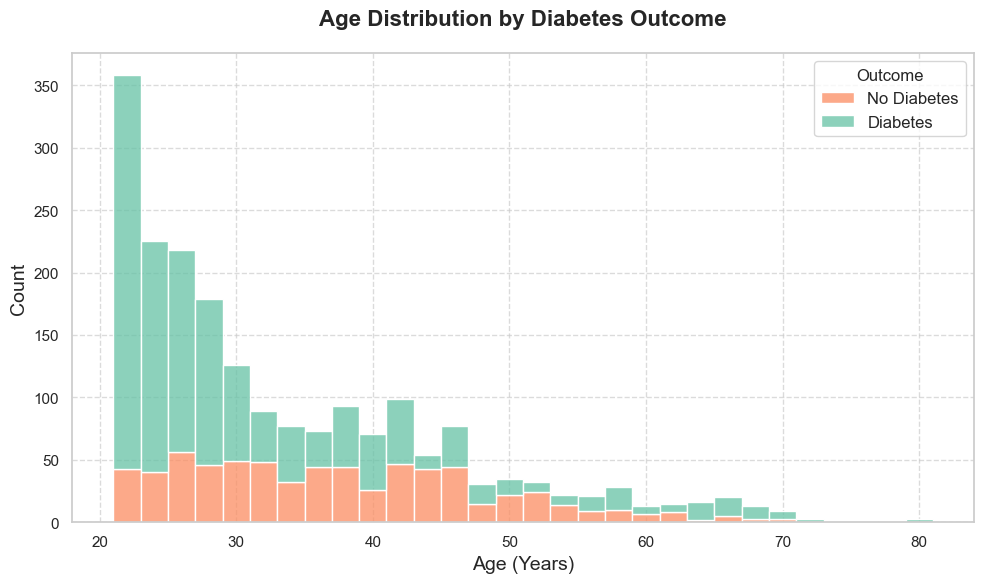

In [42]:
# 4. Age Distribution by Outcome
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='Outcome', multiple='stack', bins=30, palette='Set2')
plt.title('Age Distribution by Diabetes Outcome', pad=20, fontsize=16, weight='bold')
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Outcome', labels=['No Diabetes', 'Diabetes'], fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('plots/age_distribution.png', dpi=300)
plt.show()
# plt.close()


ValueError: num must be an integer with 1 <= num <= 9, not 10

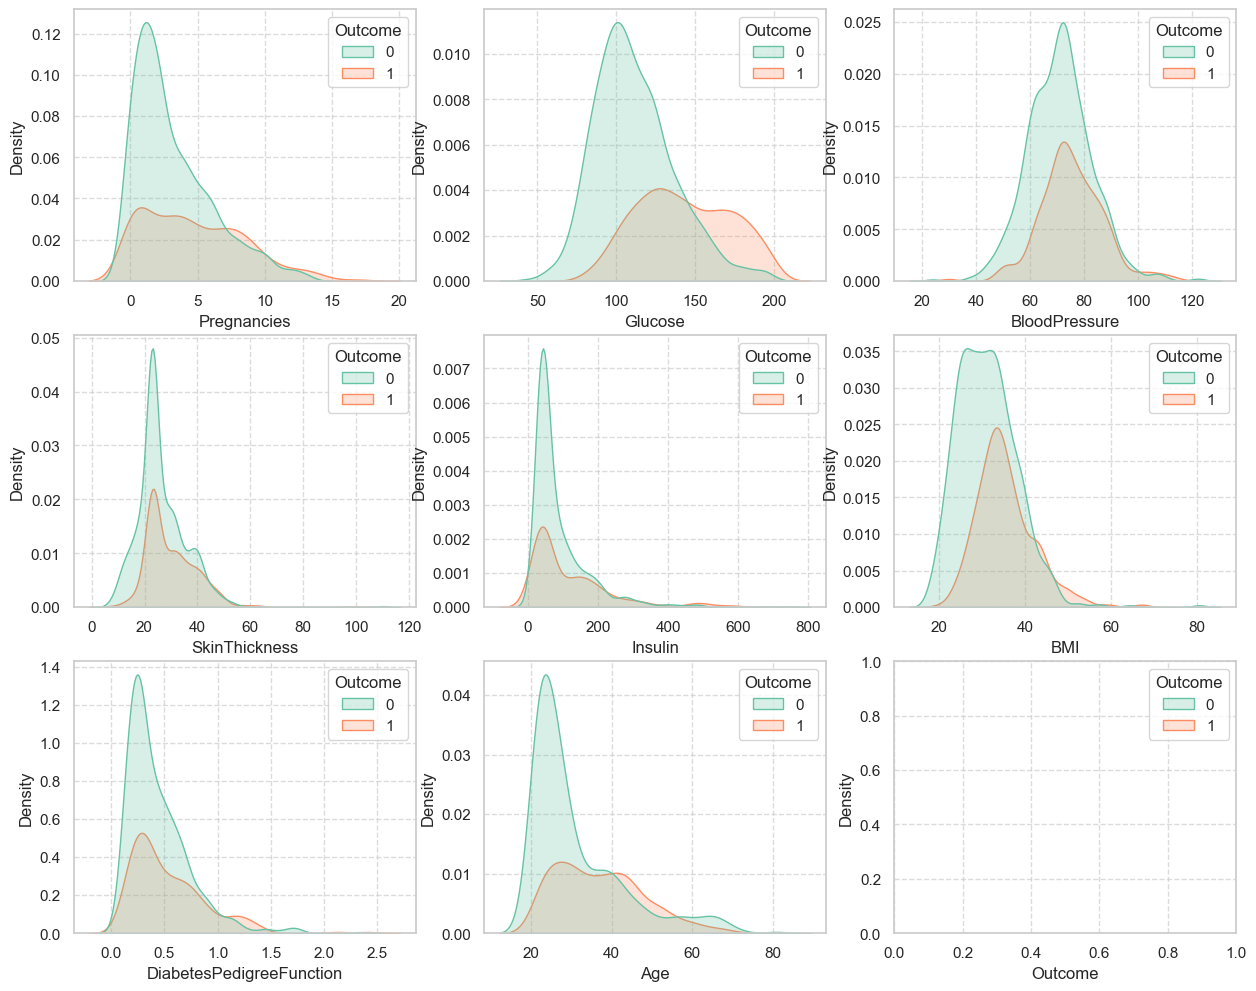

In [44]:
# 5. Feature Distributions (KDE Plots)
plt.figure(figsize=(15, 12))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(data=df, x=col, hue='Outcome', fill=True, palette='Set2')
    # plt.title(f'{col} Distribution', fontsize=14, weight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('plots/feature_distributions.png', dpi=300)
plt.show()
# plt.close()

In [45]:
# CELL 15: CODE
# Ensure categorical columns exist
categorical_cols = ['BMI_Category', 'Glucose_Level', 'Age_Group']
for col in categorical_cols:
    if col not in df.columns:
        raise ValueError(f'Missing categorical column: {col}')

X = df.drop(['Outcome', 'BMI_Category', 'Glucose_Level', 'Age_Group'], axis=1)
y = df['Outcome']

In [46]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)


In [47]:
# Combine numerical and encoded categorical features
X = pd.concat([X, X_encoded], axis=1)


In [48]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1600, 18)
X_test shape: (400, 18)


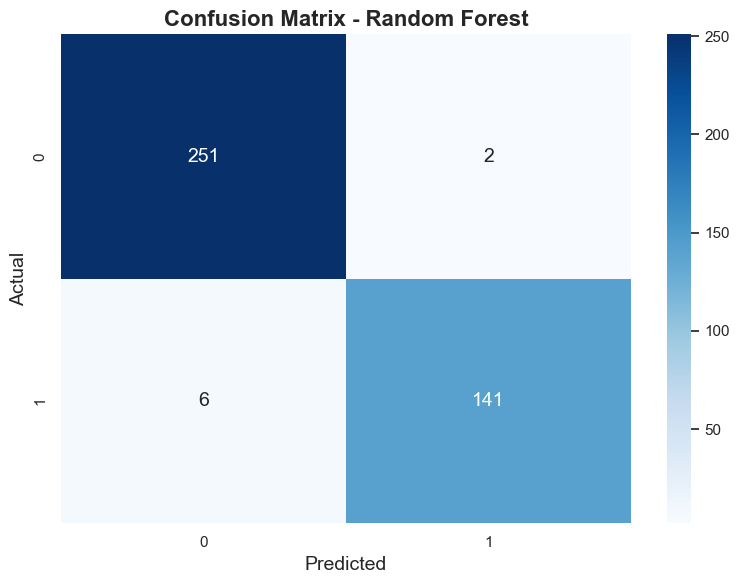

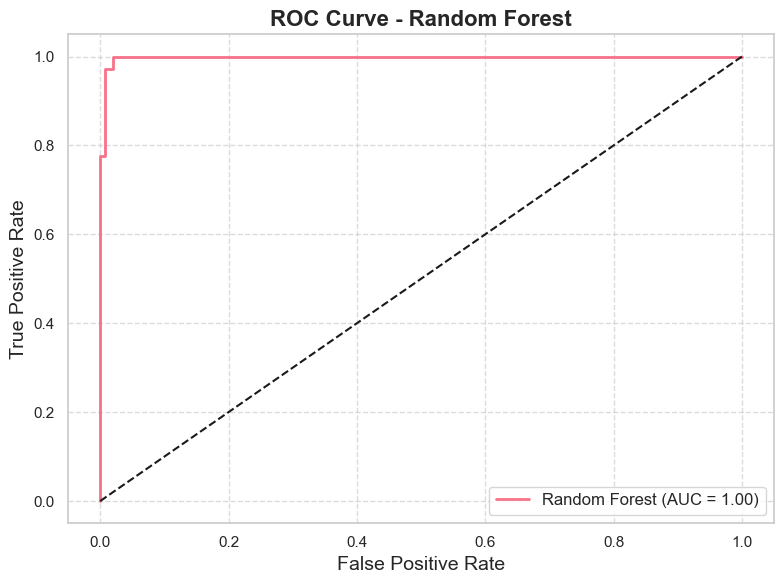

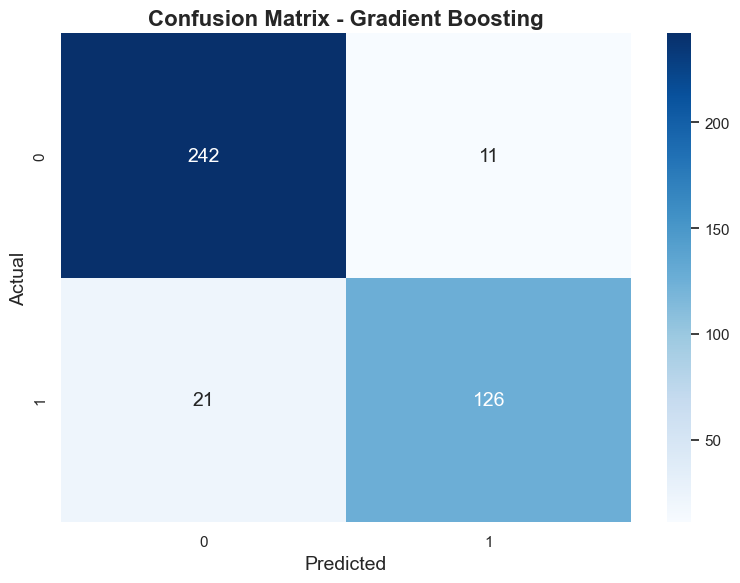

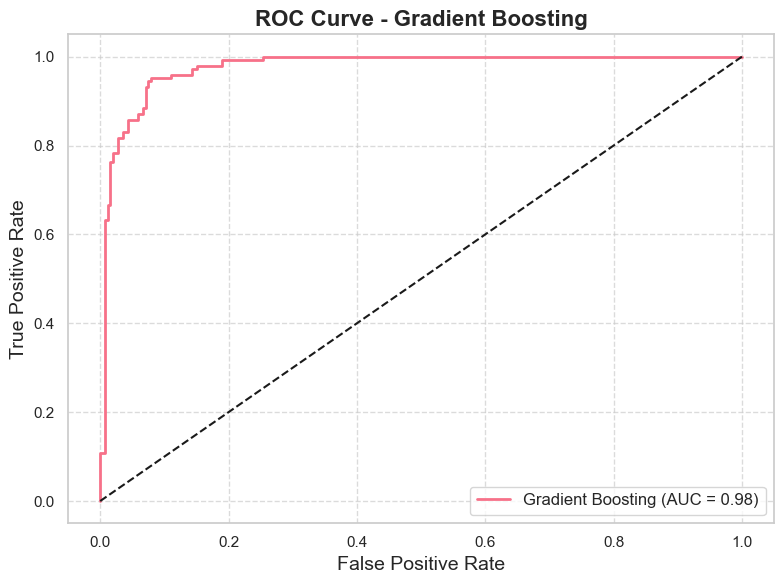

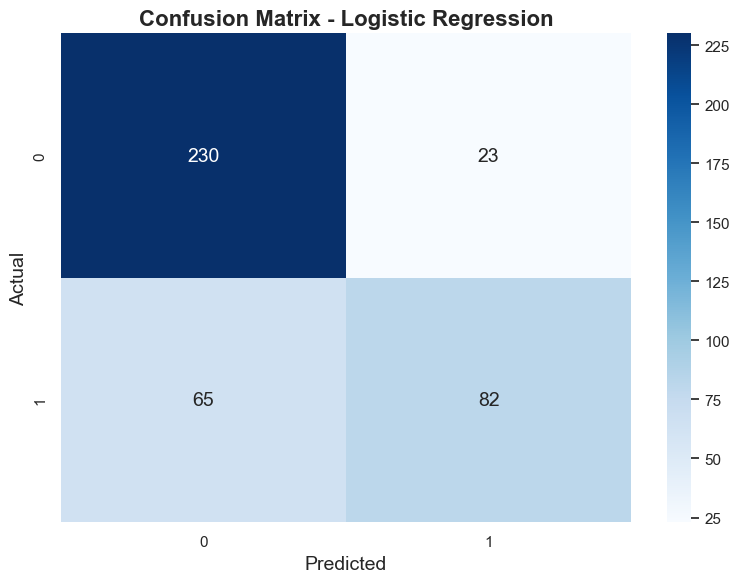

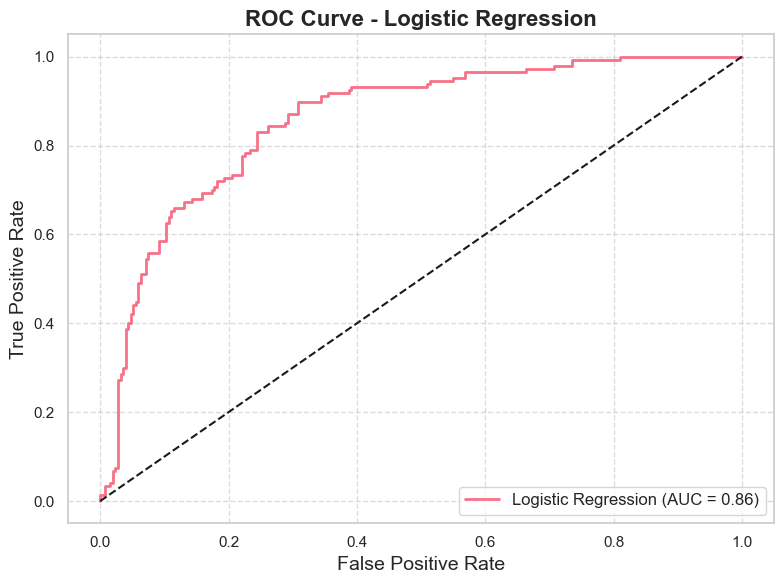

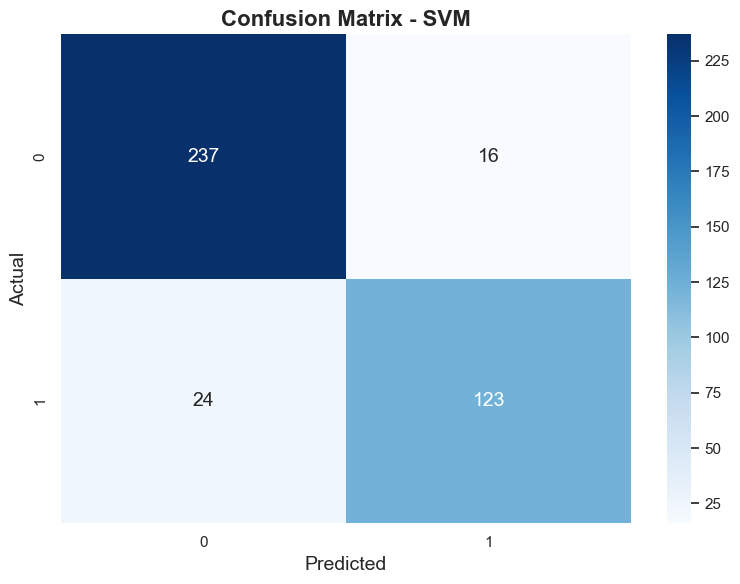

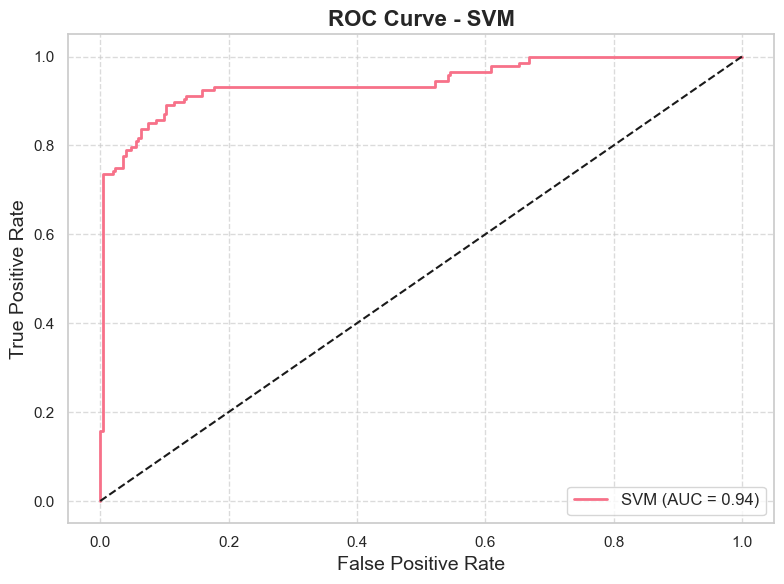

In [51]:
# CELL 18: CODE
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = []
best_rf_model = None

for name, model in models.items():
    # Define hyperparameter grid
    if name == 'Random Forest':
        param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
    elif name == 'Gradient Boosting':
        param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
    elif name == 'Logistic Regression':
        param_grid = {'C': [0.1, 1, 10]}
    else:
        param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Best model
    current_model = grid_search.best_estimator_

    # Save Random Forest model with best parameters
    if name == 'Random Forest' and grid_search.best_params_ == {'max_depth': None, 'n_estimators': 200}:
        best_rf_model = current_model

    # Predictions
    y_pred = current_model.predict(X_test_scaled)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # ROC Curve
    y_prob = current_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results.append({
        'Model': name,
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'ROC AUC': roc_auc
    })

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 14})
    plt.title(f'Confusion Matrix - {name}', fontsize=16, weight='bold')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'plots/confusion_matrix_{name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()
    plt.close()

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curve - {name}', fontsize=16, weight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'plots/roc_curve_{name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()
    plt.close()

In [52]:
results_df = pd.DataFrame(results)
results_df

,Model,Best Parameters,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,"{'max_depth': None, 'n_estimators': 200}",0.98,0.986014,0.959184,0.972414,0.997903
1,Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 200}",0.92,0.919708,0.857143,0.887324,0.976258
2,Logistic Regression,{'C': 1},0.78,0.780952,0.557823,0.650794,0.858433
3,SVM,"{'C': 10, 'kernel': 'rbf'}",0.90,0.884892,0.836735,0.860140,0.942163


In [53]:
# CELL 21: CODE
# Save the Random Forest model, scaler, and feature names
try:
    if best_rf_model is not None:
        pickle.dump(best_rf_model, open('diabetes_model.pkl', 'wb'))
        pickle.dump(scaler, open('scaler.pkl', 'wb'))
        pickle.dump(feature_names, open('feature_names.pkl', 'wb'))
        print('Random Forest model, scaler, and feature names saved successfully.')
    else:
        print('Error: Random Forest model with specified parameters not found.')
except Exception as e:
    print(f'Error saving artifacts: {e}')

Random Forest model, scaler, and feature names saved successfully.
